In [2]:
# install Prophet to the notebook
!pip install fbprophet

In [0]:
# import necessary libralies
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet

import google.colab.drive

%matplotlib inline

In [4]:
# mouth google drive
google.colab.drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# change directory
os.chdir('/content/drive/My Drive/201910_Latest_View/to_Git')

In [0]:
# read data
df_bull = pd.read_csv('data_bull.csv')
df_bear = pd.read_csv('data_bear.csv')

In [0]:
# convert date
df_bull['ds'] = pd.to_datetime(df_bull['ds'])
df_bear['ds'] = pd.to_datetime(df_bear['ds'])

In [0]:
# separate dataframe 
df_y = df_bull[['ds', 'sales']].copy() # same as df_bear
df_y = df_y[df_y['ds'] < '2019-10-01'].copy()
df_y.columns = ['ds', 'y'] # change column name
df_y['y'] = df_y['y'].apply(lambda x:int(x.replace(',', ''))) # convert to integer if sales is text
event_columns = [i for i in df_bull.columns if i not in ['sales']] # same as df_bear
df_events_bull = df_bull[event_columns].copy()
df_events_bear = df_bear[event_columns].copy()

In [0]:
# remove outliers
# https://facebook.github.io/prophet/docs/outliers.html
ds_out = ['2016-02-03', '2018-02-27', '2018-02-28', '2019-09-04']
for i in ds_out:
    df_y.loc[df_y['ds'] == i, 'sales'] = None


# create the dataframe for holidays
events = [i for i in df_bull.columns if i not in ['ds', 'sales']]

df_holidays_bull = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window']) # create empty dataframe
df_holidays_bear = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window']) # create empty dataframe

for i in events: # bull iteration
    tmp = pd.DataFrame({
        'holiday': str(i),
        'ds': df_events_bull.loc[df_events_bull[i] == 1, 'ds'],
        'lower_window': 0,
        'upper_window': 1
    })
    df_holidays_bull = df_holidays_bull.append(tmp)

for i in events: # bear iteration
    tmp = pd.DataFrame({
        'holiday': str(i),
        'ds': df_events_bear.loc[df_events_bear[i] == 1, 'ds'],
        'lower_window': 0,
        'upper_window': 1
    })
    df_holidays_bear = df_holidays_bear.append(tmp)

In [0]:
# fit model and forecast
# df_y_model = df_y[df_y['ds'] >= '2017-01-01'].copy()
df_y_model = df_y[df_y['ds'] >= '2015-01-01'].copy()

In [11]:
# bull scenario
m_bull = Prophet(growth='linear', daily_seasonality=False, holidays=df_holidays_bull)
m_bull.fit(df_y_model)
future_bull = m_bull.make_future_dataframe(periods=458)
forecast_bull = m_bull.predict(future_bull)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [0]:
# bear scenario
m_bear = Prophet(growth='linear', daily_seasonality=False, holidays=df_holidays_bear)
m_bear.fit(df_y_model)
future_bear = m_bear.make_future_dataframe(periods=458)
forecast_bear = m_bear.predict(future_bear)

In [0]:
# accuary check
part_bull = forecast_bull[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
part_bear = forecast_bear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

part_bull.columns = ['ds', 'bull_yhat', 'bull_yhat_lower', 'bull_yhat_upper']
part_bear.columns = ['ds', 'bear_yhat', 'bear_yhat_lower', 'bear_yhat_upper']

outcome = part_bull.merge(part_bear, on='ds', how='left')
outcome = outcome.merge(df_y_model[['ds','y']], on='ds', how='left')

In [14]:
outcome.head()

,ds,bull_yhat,bull_yhat_lower,bull_yhat_upper,bear_yhat,bear_yhat_lower,bear_yhat_upper,y
0,2015-01-01,-33548.146269,-923243.010088,8.692177e+05,-33548.146269,-964089.861123,8.803340e+05,78158.0
1,2015-01-02,236366.392082,-618348.348193,1.189760e+06,236366.392082,-617598.284048,1.236317e+06,84475.0
2,2015-01-03,142839.140124,-748826.164396,1.030604e+06,142839.140124,-741849.525285,1.080344e+06,74434.0
3,2015-01-04,122219.350840,-820687.844757,1.052405e+06,122219.350840,-781275.759498,1.064533e+06,80602.0
4,2015-01-05,262919.202397,-596354.172593,1.213183e+06,262919.202397,-643927.066415,1.199344e+06,97679.0


In [0]:
# sum by month
ym = outcome.set_index('ds')
df_ym = ym.set_index([ym.index.year, ym.index.month])
df_ym.index.names = ['year', 'month']
df_ym.sort_index(inplace=True)

df_ym_sum = df_ym.sum(level=['year', 'month'])

In [0]:
# difference 
df_ym_sum['diff_bull'] = (df_ym_sum['bull_yhat'] / df_ym_sum['y'] - 1) * 100 
df_ym_sum['diff_bear'] = (df_ym_sum['bear_yhat'] / df_ym_sum['y'] - 1) * 100 

In [0]:
# change pandas format
pd.options.display.float_format = '{:.2f}'.format

In [18]:
# print differences
df_ym_sum.iloc[36:57]

bull_yhat  bull_yhat_lower  ...  diff_bull  diff_bear
year month                                ...                      
2018 1      76572463.69      48231099.83  ...     -14.52     -14.52
     2      54028309.25      28648258.33  ...       0.85       0.85
     3      61522224.02      33375311.57  ...      -0.32      -0.32
     4      67247783.62      39596909.14  ...      24.77      24.77
     5      74556326.35      46687719.18  ...      -7.28      -7.28
     6      74439043.18      47171893.99  ...      -8.24      -8.24
     7      78367577.49      49874490.08  ...     -15.38     -15.38
     8      68233815.65      39819037.69  ...       9.77       9.77
     9      79451338.96      52585292.20  ...      16.32      16.32
     10    100722524.93      72556559.47  ...      20.21      20.21
     11     99299642.74      71880391.62  ...     -10.81     -10.81
     12     82298128.47      54075107.71  ...       9.42       9.42
2019 1     100630190.71      72321460.60  ...     -17.61     -17.61
     2      75396494.97      50319799.26  ...      -1.32      -1.32
     3     106730939.71      78694858.03  ...       0.01       0.01
     4     101596625.62      74368498.95  ...      15.14      15.14
     5     108857028.65      80455069.19  ...       0.51       0.51
     6     115241189.16      87807094.08  ...      -2.49      -2.49
     7     122416480.82      94034450.80  ...      13.68      13.68
     8     114552984.26      86207084.98  ...      -4.96      -4.96
     9     137580740.64     110089929.49  ...      -5.15      -5.15

[21 rows x 9 columns]

In [19]:
# print forecasts
df_ym_sum.iloc[57:]

bull_yhat  bull_yhat_lower  ...  diff_bull  diff_bear
year month                                ...                      
2019 10    123515573.15      95312661.03  ...        inf        inf
     11    121494924.18      94050178.28  ...        inf        inf
     12    105740730.12      76962984.78  ...        inf        inf
2020 1     123930410.37      95368905.28  ...        inf        inf
     2      99798295.01      73050581.29  ...        inf        inf
     3     129997929.84     101591267.77  ...        inf        inf
     4     124077580.90      96583077.07  ...        inf        inf
     5     131993139.02     103389095.81  ...        inf        inf
     6     138042330.18     110643703.42  ...        inf        inf
     7     145607276.52     117146885.38  ...        inf        inf
     8     137944036.01     109551517.42  ...        inf        inf
     9     160235582.45     132682865.51  ...        inf        inf
     10    146642253.38     118427724.12  ...        inf        inf
     11    144259538.42     116653341.21  ...        inf        inf
     12    129244194.39     100688695.33  ...        inf        inf

[15 rows x 9 columns]

In [20]:
# print forecasts for 2020 total
df_ym_sum.iloc[60:].sum()

bull_yhat         1611772566.49
bull_yhat_lower   1275777659.60
bull_yhat_upper   1945137387.22
bear_yhat         1408338187.17
bear_yhat_lower   1073463364.79
bear_yhat_upper   1744525733.42
y                          0.00
diff_bull                   inf
diff_bear                   inf
dtype: float64

In [21]:
# print forecasts for 2019 total
df_ym_sum.iloc[48:60].sum()

bull_yhat         1333753902.00
bull_yhat_lower   1000624069.45
bull_yhat_upper   1668367370.82
bear_yhat         1333753902.00
bear_yhat_lower   1000626671.31
bear_yhat_upper   1668534357.37
y                  993258922.00
diff_bull                   inf
diff_bear                   inf
dtype: float64

In [22]:
# print 2019 actual
df_ym_sum.iloc[48:57].sum()

bull_yhat          983002674.55
bull_yhat_lower    734298245.36
bull_yhat_upper   1232777651.29
bear_yhat          983002674.55
bear_yhat_lower    734089252.86
bear_yhat_upper   1233870396.15
y                  993258922.00
diff_bull                 -2.19
diff_bear                 -2.19
dtype: float64

In [23]:
# print 2019 diff %
actual = df_ym_sum.iloc[48:57].sum()
print((actual['bull_yhat'] / actual['y'] - 1) * 100)

-1.0325854847702542


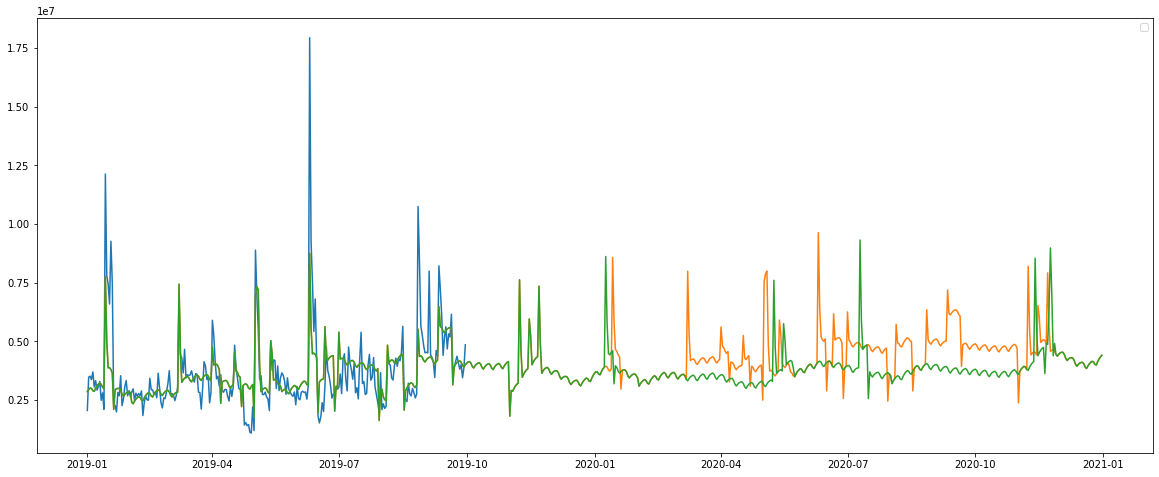

In [24]:
# visualize
df_visualize = outcome.loc[outcome['ds'] >= '2019-01-01']

plt.figure(figsize=(20,8))

plt.plot(df_visualize['ds'], df_visualize['y'])
plt.plot(df_visualize['ds'], df_visualize['bull_yhat'])
plt.plot(df_visualize['ds'], df_visualize['bear_yhat'])
plt.legend()
plt.show()

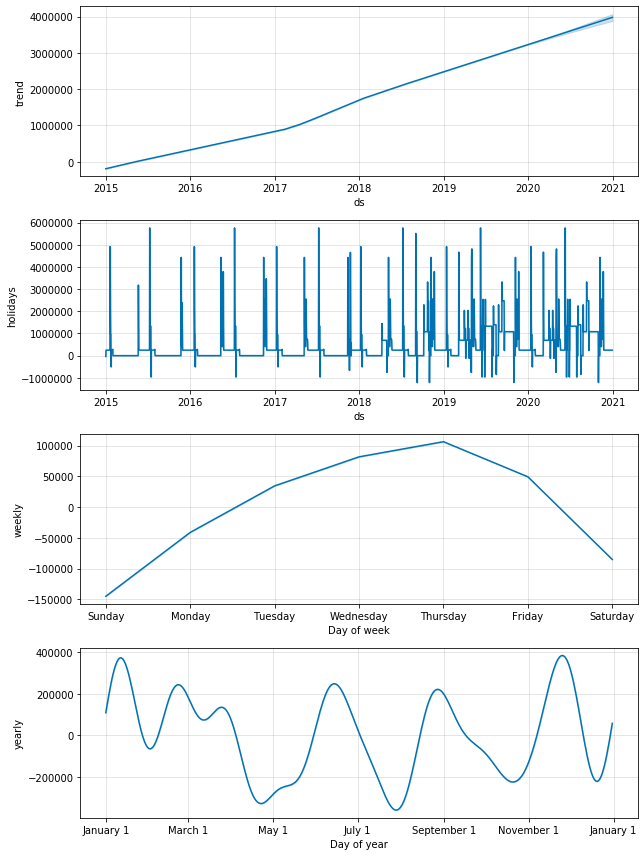

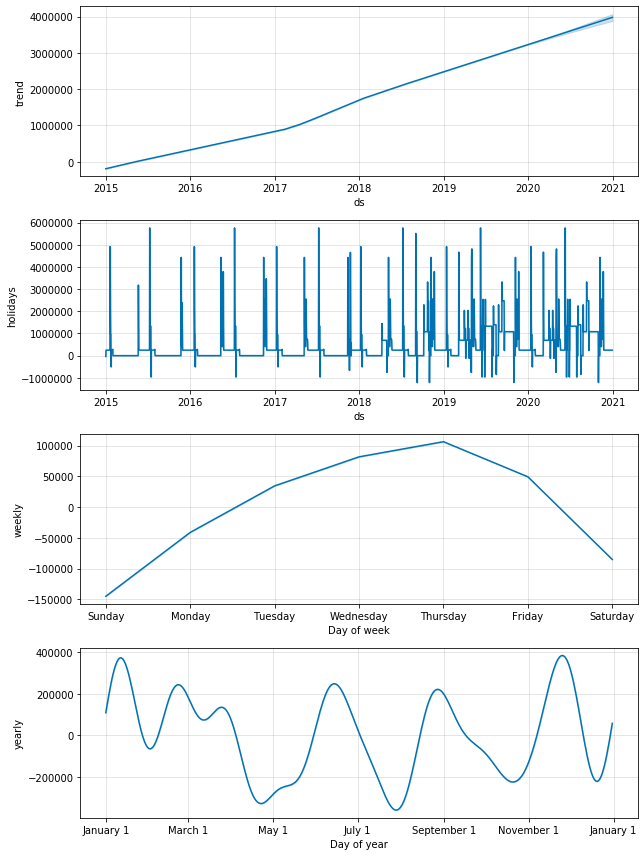

In [25]:
m_bull.plot_components(forecast_bull)

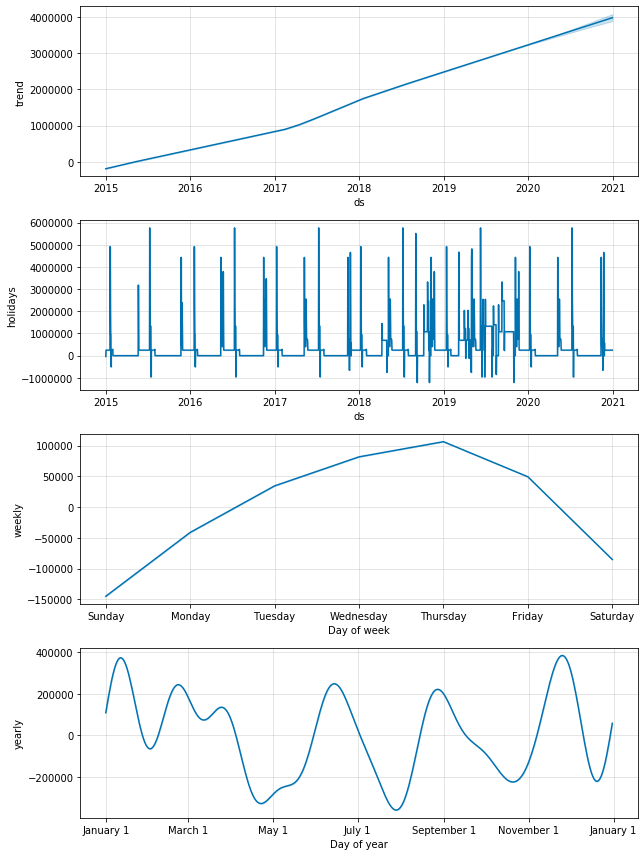

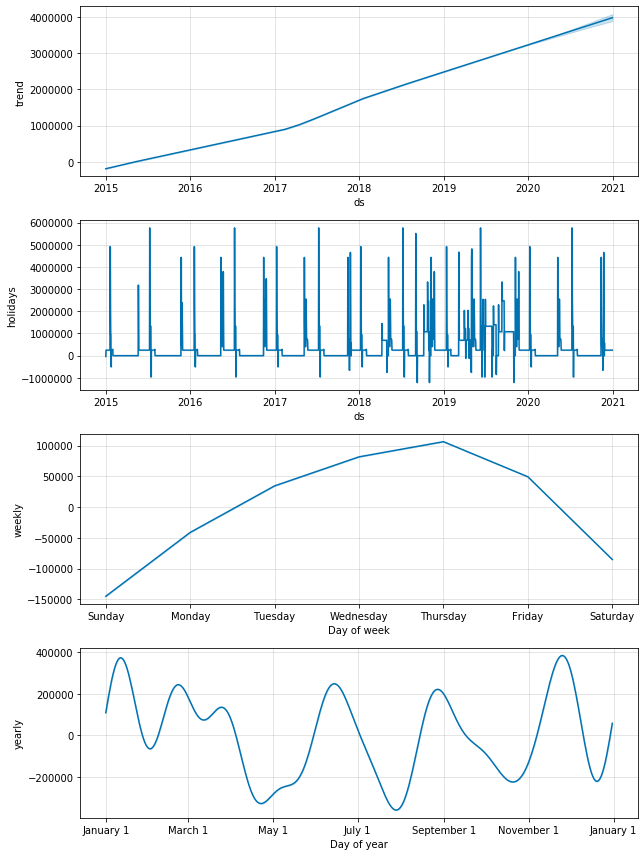

In [26]:
m_bear.plot_components(forecast_bear)

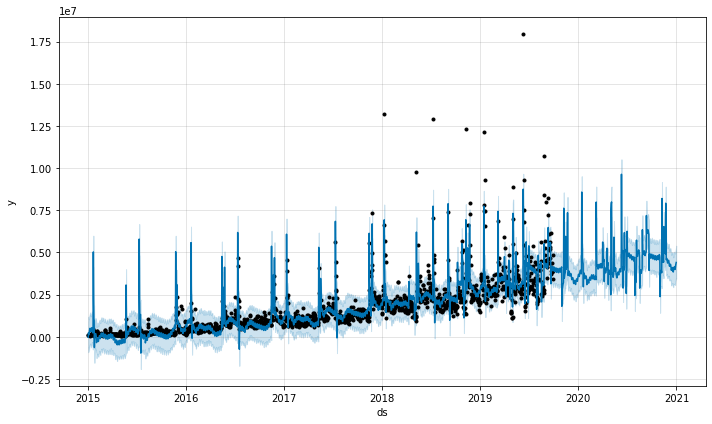

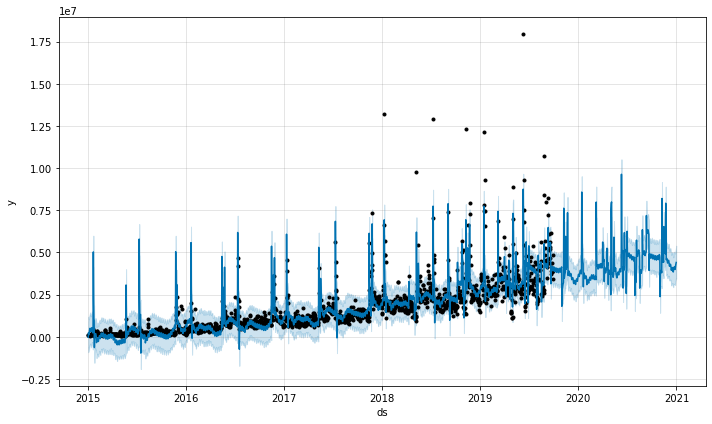

In [27]:
# prophet plot
m_bull.plot(forecast_bull)

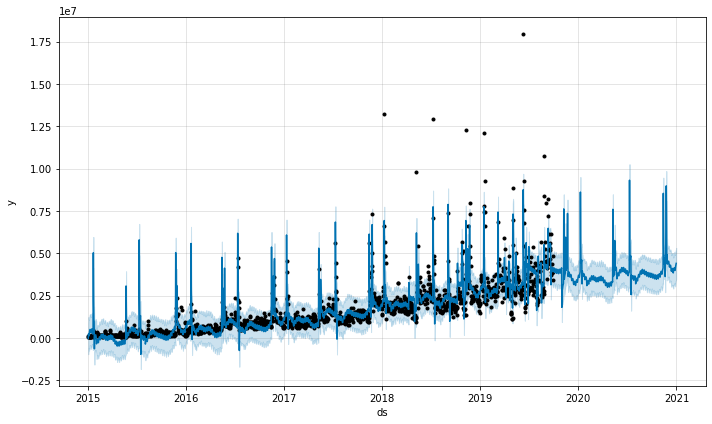

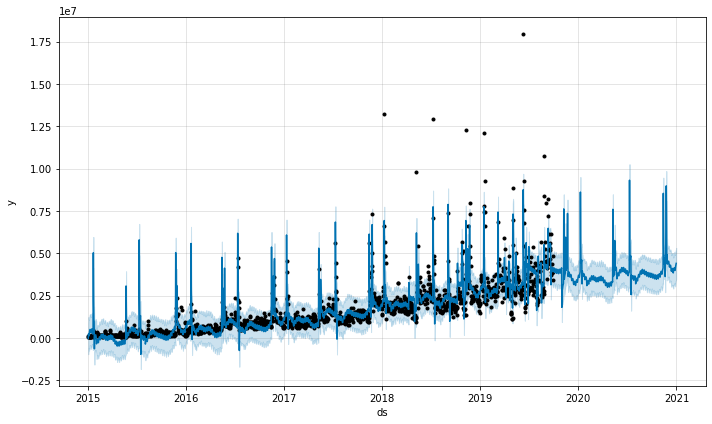

In [28]:
# prophet plot
m_bear.plot(forecast_bear)